In [2]:
import uproot
import awkward as ak
import numpy as np

In [3]:
# open file: https://opendata.cern.ch/record/80010 MC simulation electroweak boson nominal samples
# mc20_13TeV_MC_Sh_2211_Zmumu_maxHTpTV2_BFilter_file_index.json
file = uproot.open("DAOD_PHYSLITE.37621365._000015.pool.root.1")

### Get to know your data
What objects are in this file? What's the name of the ttree? 

In [56]:
#file.keys()

In [44]:
# accessing ttree
# tree = file["insert_tree_name_here"]
tree = file["CollectionTree"]

How many branches are in this ttree? 

In [53]:
#len(tree)
#tree.keys()
#tree.show()
print("Number of branches:", len(tree))

Number of branches: 1360


We can read TBranches as arrays using tree.arrays([insert_list_of_branch_names_here]). Fill in the blanks associated with Muons.

In [7]:
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
# Muons = tree.arrays([...])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"])

How many events are in this tree? 

In [58]:
#len(Electrons)
print("Number of events:", len(Muons))

Number of events: 200000


[give some explanation about event ordering] How many electrons are in the 80th event? What are their charges. How many muons are in the 80th event? What are their charges?

In [34]:
# 4 electrons with charges:
Electrons["AnalysisElectronsAuxDyn.charge"][79]

<Array [1, -1, -1, 1] type='4 * float32'>

In [35]:
# 2 muon with charge:
Muons["AnalysisMuonsAuxDyn.charge"][79]

<Array [1, 1] type='2 * float32'>

To make our lives easier, [ak.zip](https://awkward-array.org/doc/main/reference/generated/ak.zip.html) combines arrays into a single structure as a collection of records. 

In [10]:
e = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"]
})
mu = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})

What's the total number of electrons in the data set? What about muons? The function [ak.num](https://awkward-array.org/doc/main/reference/generated/ak.num.html) may help.

In [64]:
print("Total number of electrons: ", sum(ak.num(e)))
print("Total number of muons: ", sum(ak.num(mu)))

Total number of electrons:  54852
Total number of muons:  397347


## Ready for analysis

Calculate the tranverse momentum components for electrons and Energy, using the above.  

In [36]:
#  Momentum components
def Px(pt, phi):
    return pt*np.cos(phi)

def Py(pt,phi):
    return pt*np.sin(phi)

def Pz(pt,eta):
    return pt*np.sinh(eta)

def E(pt, eta, m):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

e_px = Px(e.pt,e.phi)
e_py = Py(e.pt,e.phi)
e_pz = Pz(e.pt,e.eta)
e_E = E(e.pt,e.eta,e.mass)

The invariant mass of two oppositely charged leptons is defined as:
\begin{equation}
m_0 = \sqrt{(\sum{E})^2-(\sum{p_x})^2-(\sum{p_y})^2-(\sum{p_z})^2}
\end{equation}

Create a function, using the functions above for energy and momentum components, that calculates the invariant mass in GeV.

In [12]:
def calc_invm(p1, p2):
    sumpx = Px(p1.pt,p1.phi) + Px(p2.pt,p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt,p2.phi)
    sumpz = Pz(p1.pt,p1.eta) + Pz(p2.pt,p2.eta)
    try:
        sumE = E(p1.pt,p1.eta,p1.mass) + E(p2.pt,p2.eta,p2.mass)
    except AttributeError:
        sumE = E(p1.pt,p1.eta,0) + E(p2.pt,p2.eta,0)    
    
    invm = np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)
    return invm/1000.0

### Data Selection

As shown in Frank's workshop, we can mask awkward arrays to apply cuts for data selection. 

Make a selection of events with more than two electrons and with electron pt greater than 25 GeV. This should leave you with a total of 2130 electrons. 

In [65]:
#e_cut = (__insert_cut_here)
e_cut = ((e.pt>25000) & (ak.num(e.charge) >=2))
cleaned_e = e[e_cut]
# check 
sum(ak.num(cleaned_e))

2130

In [68]:
# function answer (might be hw to do it for muons and combine)
def selection_calc(lepton):
    cut = ((lepton.pt > 25000) & (ak.num(lepton.charge) >= 2))
    data_cut = lepton[cut]
    pairs = ak.flatten(ak.combinations(data_cut, 2, axis = 1))
    opp_charge = pairs[(ak.prod([pairs[:]["0"].charge, pairs[:]["1"].charge], axis =0) == -1)]
    invm = calc_invm(opp_charge[:]["0"],opp_charge[:]["1"])
    return invm

In [15]:
e_invm = selection_calc(e)
m_invm = selection_calc(mu)
leptons = np.concatenate((e_invm,m_invm))

The peak of the histogram is at 90.23515102267265 GeV with 10370.0 counts.


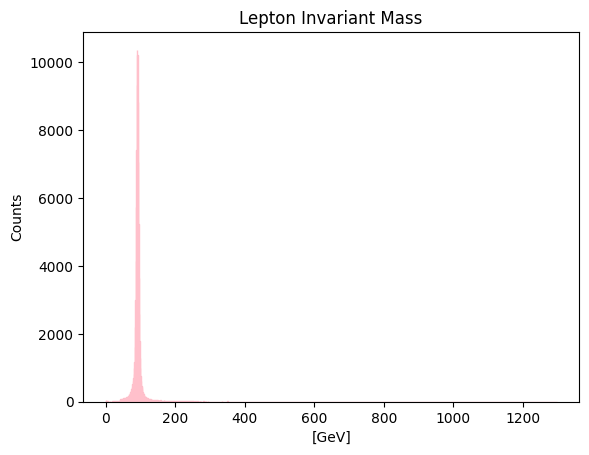

In [20]:
import matplotlib.pyplot as plt

bin_edges = np.arange(min(leptons), max(leptons) + 5) - 0.5
counts, bins, _ = plt.hist(leptons, bins=bin_edges, edgecolor='pink')

plt.title("Lepton Invariant Mass")
plt.xlabel("[GeV]")
plt.ylabel("Counts")

# Find the bin with the highest count (the peak)
peak_bin_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bins[peak_bin_index] + bins[peak_bin_index + 1]) / 2  # Bin center

print(f"The peak of the histogram is at {peak_bin_center} GeV with {counts[peak_bin_index]} counts.")
plt.show()